# IMPORT LIBRARIES

In [4]:
# import used libraries
import pandas as pd                        # pandas for data analysis
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt            # matplotlib for data visualisation
from scipy import stats  
import numpy as np

***
# Loading data 

In [5]:
DIR = "../data/"

#read
ENT_TIMESERIES_PATH = DIR + "processed_timeseries.tsv.zip"
ENT_CHANNELS_PATH   = DIR + "scored_channels.tsv.zip"
ENT_METADATA_PATH   = DIR + "ent_metadata_en.tsv.zip"

In [6]:
# entertainment timeseries
ent_timeseries = pd.read_csv(ENT_TIMESERIES_PATH)
ent_timeseries.datetime = pd.to_datetime(ent_timeseries.datetime)

# entertainment channels
ent_channels   = pd.read_csv(ENT_CHANNELS_PATH)
ent_channels.join_date = pd.to_datetime(ent_channels.join_date)

# entertainment metadata
ent_metadata   = pd.read_csv(ENT_METADATA_PATH)
ent_metadata.upload_date = pd.to_datetime(ent_metadata.upload_date)

***
# Display dataframes

In [7]:
#sort channels by evolution score
ent_channels.sort_values(by=['evo_score'], inplace=True, ascending=False)

In [8]:
#rename channel column in metadata
ent_metadata.rename(columns={'channel_id': 'channel'}, inplace=True)

#add column with has_buzzed in metadata
ent_metadata = pd.merge(ent_metadata, ent_channels[['channel', 'has_buzzed']], on='channel')

***
# Analysis parameter 
Let's add these informations on each videos from metadata
- `numwords` : number of words in the title 
- `num_capital_word`: number of words in capital letter in title
- `is_capital_title` : 1 if there is more than 2 words in capital letter in the title, 0 otherwise
- `feat` : 1 if the title contains a a word in the list of `featuring_wordsets`, 0 otherwise
- `is_tags` : 1 if the video has tags, 0 otherwise
- `numtags` : the number of tags used in the video


##### NUMWORDS

In [9]:
#counts the number of words in a string
def count_words_simple(string):
    return len(string.split(" "))
    
#numwords in title
ent_metadata['numwords'] = ent_metadata["title"].apply(count_words_simple)

##### CAPITAL TITLE

In [10]:
#number of capital words in title
ent_metadata['num_capital_word'] = ent_metadata["title"].apply(lambda x : sum(map(str.isupper, x.split())))

#capital title if 2 or more words are capital
ent_metadata['is_capital_title'] = (ent_metadata.num_capital_word >= 2).astype(int)

##### FEATURINGS

In [11]:
#featuring 
featuring_wordsets = ['ft', 'ft.', 'feat.', 'feat', 'featuring', 'collab']

# is_in_string is a fuction returning 1 if a word from a wordlist is in a string, 0 otherwise
def is_in_string (string, wordlist):
    return any(word in string.lower().split(' ') for word in wordlist) * 1

ent_metadata['feat'] = ent_metadata['title'].apply(is_in_string, args=[featuring_wordsets])

##### NUMBER OF TAGS

In [12]:
# counts number of tags splitted by ","
def count_tags(string):
    return len(str(string).split(","))

# is there a tag ?
ent_metadata['is_tags'] = 1 - (ent_metadata['tags'].isna())*1

# number of tags
ent_metadata['numtags'] = ent_metadata["tags"].apply(count_tags) * ent_metadata['is_tags']


***
# Compute the mean of all features by channel


##### Compute all means then merge on channel

In [13]:
ent_channels = pd.merge(ent_channels,
                        ent_metadata.groupby('channel').mean()[['duration','numtags','is_capital_title','numwords','feat','is_tags','view_count']],
                        on = 'channel')
ent_channels = pd.merge(ent_channels,
                        ent_timeseries.groupby('channel').mean()[['delta_videos']], 
                        on = 'channel')

C:\Users\carol\AppData\Local\Temp\ipykernel_20336\3708084058.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ent_metadata.groupby('channel').mean()[['duration','numtags','is_capital_title','numwords','feat','is_tags','view_count']],
C:\Users\carol\AppData\Local\Temp\ipykernel_20336\3708084058.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ent_timeseries.groupby('channel').mean()[['delta_videos']],


##### Rename columns

In [14]:
ent_channels.rename(columns={'duration':'mean_duration', 
                             'numtags':'mean_numtags', 
                             'is_capital_title':'mean_capital_title',
                             'numwords':'mean_numwords',
                             'feat':'mean_feats', 
                             'is_tags':'mean_is_tags',
                             'view_count':'mean_view_count',
                             'delta_videos':'week_freq'}, inplace=True)

all_channel_parameters = ['mean_capital_title','mean_numwords','mean_feats','mean_duration','mean_numtags','mean_is_tags','week_freq']

***
# Random Forest

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = ent_channels[all_channel_parameters]
y = ent_channels['has_buzzed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# view the classification report, which contains precision
report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(report)

,0,1,accuracy,macro avg,weighted avg
precision,0.812500,0.709677,0.761905,0.761089,0.766801
recall,0.742857,0.785714,0.761905,0.764286,0.761905
f1-score,0.776119,0.745763,0.761905,0.760941,0.762628
support,140.000000,112.000000,0.761905,252.000000,252.000000


***
# Importance of features 

In [19]:
import time
import numpy as np

start_time = time.time()

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.027 seconds


FileNotFoundError: [Errno 2] No such file or directory: 'output\\file.html'

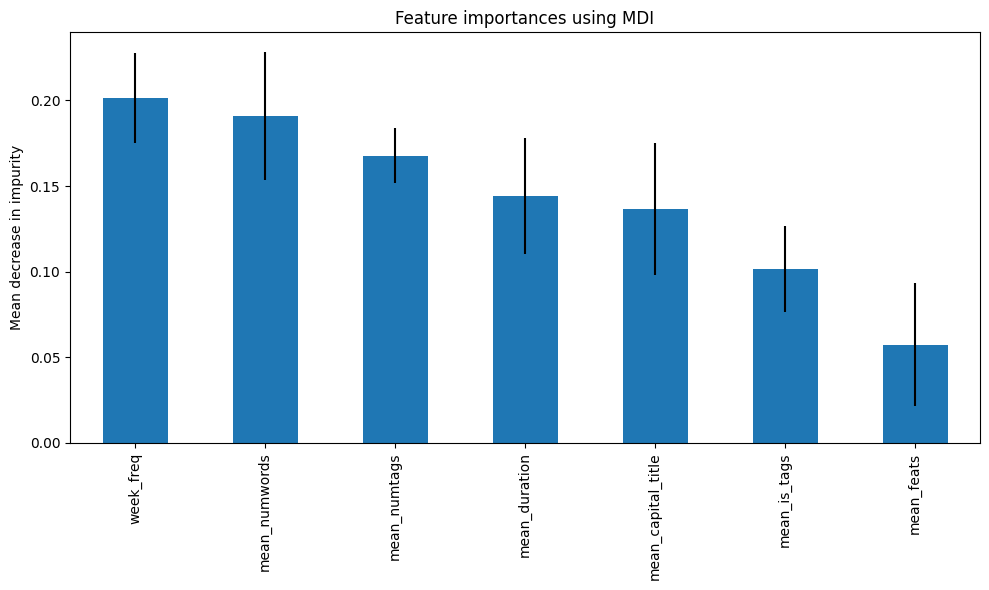

In [21]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
#forest_importances sorted by importance
forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
fig1 , ax = plt.subplots(figsize=(10, 6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig1.tight_layout()


fig = go.Figure()
fig.add_trace(go.Bar(
    x=forest_importances.index,
    y=forest_importances.values,
    orientation='v',
    marker_color='#15836D' 
))

fig.update_layout(
    barmode='group', 
    xaxis_tickangle=-45,
    width=1000,
    height=600,
    xaxis_title='Features',
    yaxis_title='Mean decrease in impurity',
    title='Importance of the features for the prediction of a channel\'s buzz',
    template=None,
    showlegend=False)
fig.update_yaxes(automargin=True)

fig.write_html("output/file.html")

In [22]:
# print the means of the channels that have buzzed
ent_channels[ent_channels['has_buzzed']==1][all_channel_parameters].mean()

mean_capital_title      0.308629
mean_numwords           9.598073
mean_feats              0.019842
mean_duration         749.191150
mean_numtags           14.513860
mean_is_tags            0.784259
week_freq               2.643893
dtype: float64

In [23]:
#print the means of the channels that have not buzzed
ent_channels[ent_channels['has_buzzed']==0][all_channel_parameters].mean()

mean_capital_title      0.216633
mean_numwords           7.869838
mean_feats              0.018552
mean_duration         613.456175
mean_numtags           13.465756
mean_is_tags            0.835413
week_freq               1.047774
dtype: float64

In [24]:
#t_test for each parameter
from scipy import stats
for param in all_channel_parameters:
    print(param)
    print(stats.ttest_ind(ent_channels[ent_channels['has_buzzed']==1][param],
                          ent_channels[ent_channels['has_buzzed']==0][param]))
                          

mean_capital_title
Ttest_indResult(statistic=5.784490906075211, pvalue=9.171988265726718e-09)
mean_numwords
Ttest_indResult(statistic=10.720068513618479, pvalue=1.0206710042984918e-25)
mean_feats
Ttest_indResult(statistic=0.387775069788715, pvalue=0.6982482023873522)
mean_duration
Ttest_indResult(statistic=1.7167135716036004, pvalue=0.08627806899952391)
mean_numtags
Ttest_indResult(statistic=1.7476896169672045, pvalue=0.08076214837756512)
mean_is_tags
Ttest_indResult(statistic=-2.8817334584801784, pvalue=0.004022207343989942)
week_freq
Ttest_indResult(statistic=6.434799034327965, pvalue=1.7544813853885127e-10)


In [25]:
#run anova test for all parameters

#compute R2
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)


stats.f_oneway(ent_channels[ent_channels['has_buzzed']==1][all_channel_parameters],ent_channels[ent_channels['has_buzzed']==0][all_channel_parameters]) 


F_onewayResult(statistic=array([ 33.46033504, 114.91986894,   0.1503695 ,   2.94710549,
         3.054419  ,   8.30438773,  41.40663861]), pvalue=array([9.17198827e-09, 1.02067100e-25, 6.98248202e-01, 8.62780690e-02,
       8.07621484e-02, 4.02220734e-03, 1.75448139e-10]))

***
# Linear regression

##### Mean video duration for each channel

In [27]:
import statsmodels.formula.api as smf
model = smf.ols(formula='mean_duration ~ C(has_buzzed)', data=ent_channels)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          mean_duration   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.947
Date:                Mon, 19 Dec 2022   Prob (F-statistic):             0.0863
Time:                        01:16:00   Log-Likelihood:                -10899.
No. Observations:                1258   AIC:                         2.180e+04
Df Residuals:                    1256   BIC:                         2.181e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            613.4562     55

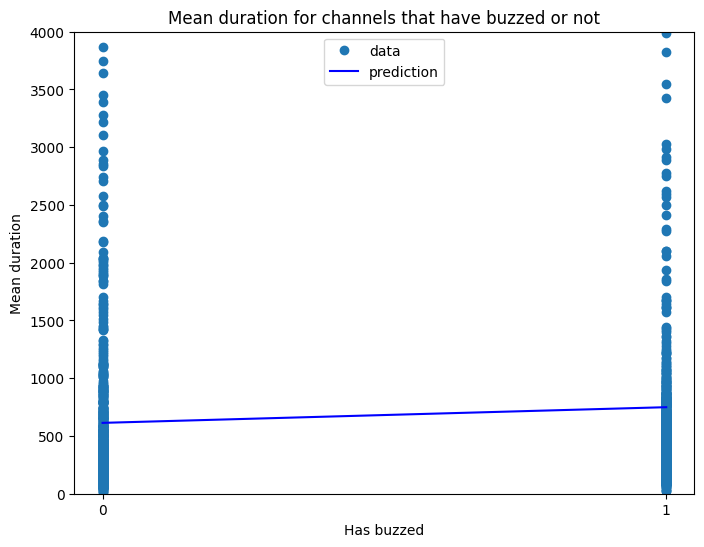

In [28]:
pred_ols = res.fittedvalues
fig, ax = plt.subplots(figsize=(8, 6))

#x is has_buzzed
x = ent_channels['has_buzzed']
#y is mean_duration
y = ent_channels['mean_duration']

ax.plot(x, y, "o", label="data")
ax.plot(x, pred_ols, "b-", label="prediction")
plt.legend()
plt.ylim(0, 4000)
plt.xticks([0, 1])
plt.title("Mean duration for channels that have buzzed or not")
plt.xlabel("Has buzzed")
plt.ylabel("Mean duration")

plt.show()

***
# Most used tags in all videos

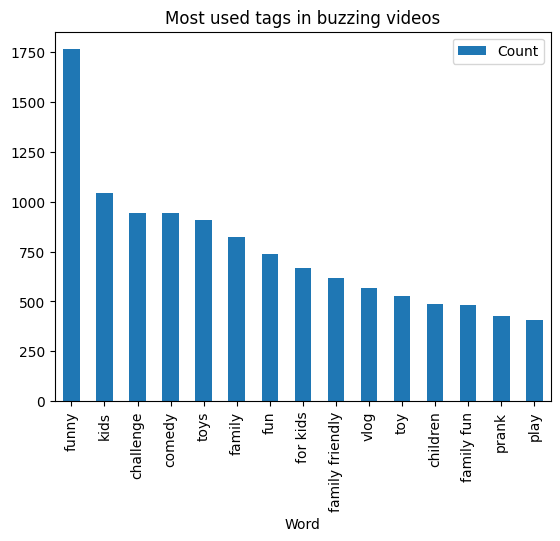

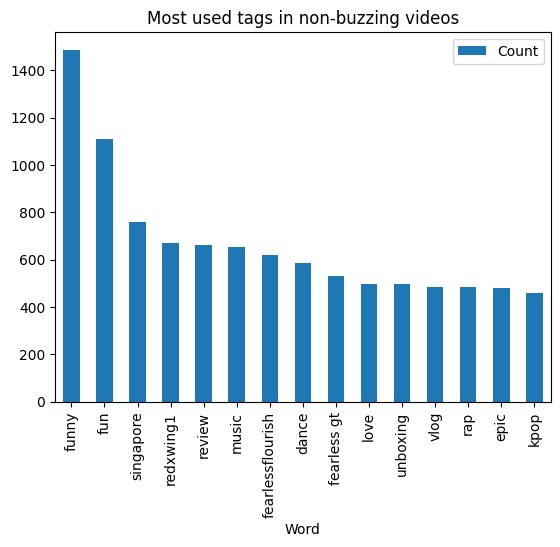

In [29]:
#remove all comomon words in a list of words
def remove_common_words(wordlist):
    common_words = ['the','a','in','of','and','to','for','on','with','is','at','by','from','as','an',
                    'be','that','this','it','its','are','have','has','had','was','were','will','would',
                    'could','can','may','might','must','should','if','then','than','so','or','but','not',
                    'no','all','any','both','each','few','more','most','other','some','such','what','when',
                    'where','which','who','whom','why','how','i','me','my','myself','we','our','ours',
                    'ourselves','you','your','yours','yourself','yourselves','he','him','his','himself',
                    'she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves',
                    'what','which','who','whom','this','that','these','those','am','is','are','was','were',
                    'be','been','being','have','has','had','having','do','does','did','doing','a','an','the',
                    'and','but','if','or','because','as','until','while','of','at','by','for','with','about',
                    'against','between','into','through','during','before','after','above','below','to',
                    'from','up','down','in','out','on','off','over','under','again','further','then','once',
                    'here','there','when','where','why','how','all','any','both','each','few','more','most',
                    'other','some','such','no','nor','not','only','own','same','so','than','too','very','s',
                    't','can','will','just','don','should','now']
    return [word for word in wordlist if word not in common_words]

from collections import Counter
  
Buz_tags = ent_metadata[ent_metadata['has_buzzed']==1].groupby('channel')['tags'].agg(pd.Series.mode).values
Nbuz_tags = ent_metadata[ent_metadata['has_buzzed']==0].groupby('channel')['tags'].agg(pd.Series.mode).values
# split() returns list of all the words in the string
split_Buz = str(Buz_tags).lower().split(',')
split_Nbuz = str(Nbuz_tags).lower().split(',')
lst_buz = Counter(remove_common_words(split_Buz)).most_common(15)
lst_not_buz = Counter(remove_common_words(split_Nbuz)).most_common(15)
df_1 = pd.DataFrame(lst_buz, columns = ['Word', 'Count'])
df_2 = pd.DataFrame(lst_not_buz, columns = ['Word', 'Count'])
df_1.plot.bar(x='Word',y='Count')
plt.title("Most used tags in buzzing videos")
df_2.plot.bar(x='Word',y='Count')
plt.title("Most used tags in non-buzzing videos")
plt.show()

***
# Boxplot

<Figure size 1000x700 with 0 Axes>

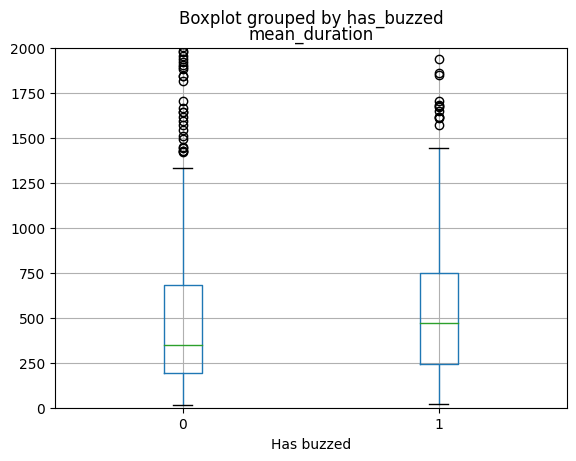

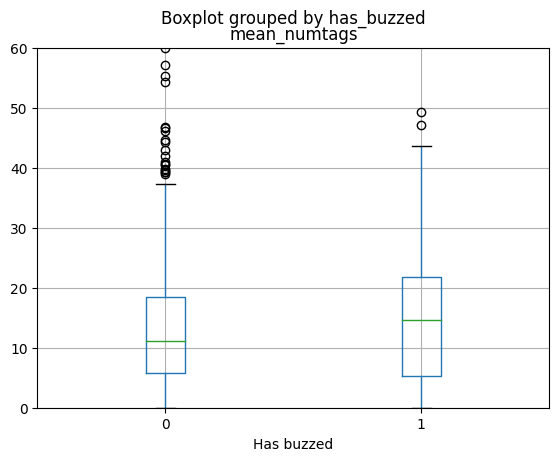

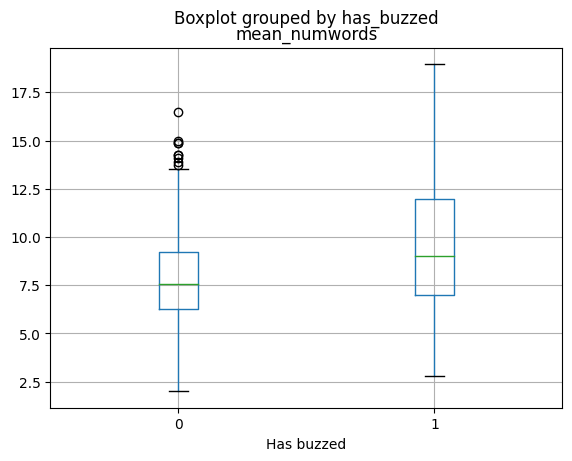

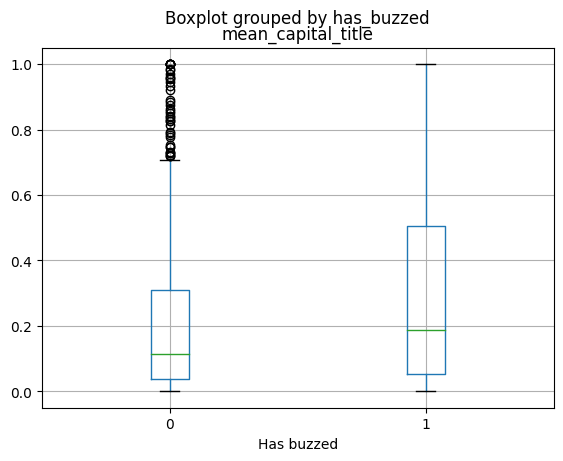

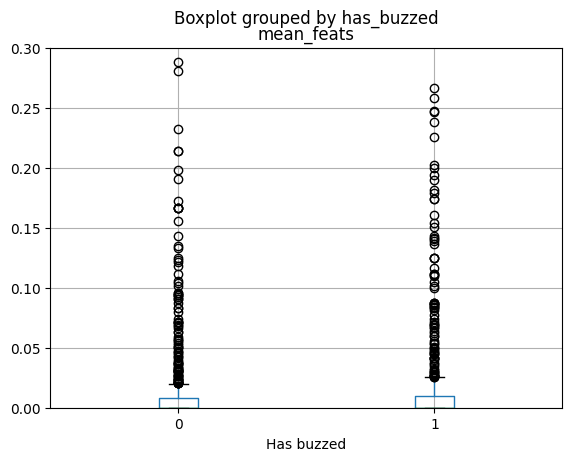

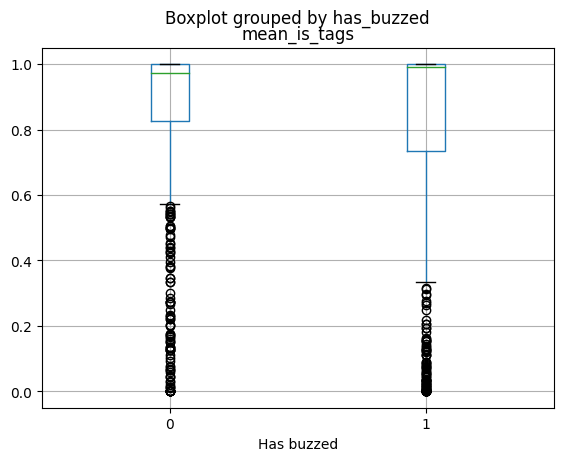

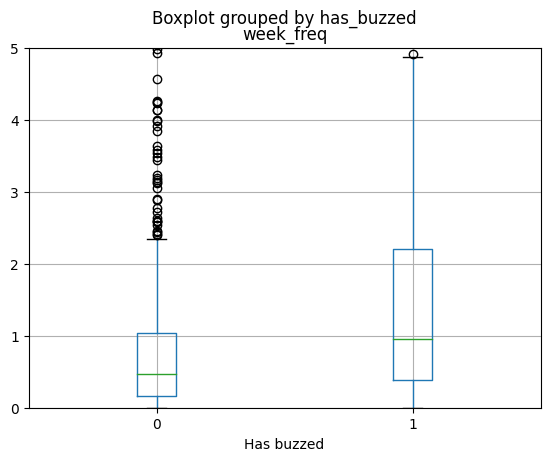

In [30]:
fig = plt.figure(figsize =(10, 7))
#boxplot for each parameter for channels that have buzzed or not

bp1 = ent_channels.boxplot(column=['mean_duration'], by=['has_buzzed'])
plt.xlabel('Has buzzed')
plt.ylim([0,2000])

bp2 = ent_channels.boxplot(column=['mean_numtags'], by=['has_buzzed'])
plt.xlabel('Has buzzed')
plt.ylim([0,60])

bp3 = ent_channels.boxplot(column=['mean_numwords'], by=['has_buzzed'])
plt.xlabel('Has buzzed')

bp4 = ent_channels.boxplot(column=['mean_capital_title'], by=['has_buzzed'])
plt.xlabel('Has buzzed')

bp5 = ent_channels.boxplot(column=['mean_feats'], by=['has_buzzed'])
plt.xlabel('Has buzzed')
plt.ylim([0,0.3])

bp6 = ent_channels.boxplot(column=['mean_is_tags'], by=['has_buzzed'])
plt.xlabel('Has buzzed')

bp7 = ent_channels.boxplot(column=['week_freq'], by=['has_buzzed'])
plt.ylim([0,5])
plt.xlabel('Has buzzed')

# show plot
plt.show()

#plot distribution of parameters for channels that have buzzed or not?

***
# Lexical analysis on title 

In [34]:
!pip install gensim
!pip install empath
!pip install wordcloud
!pip install matplotlib-venn
!pip install nltk
!pip install plotly
!pip install networkx

  Using cached gensim-4.2.0.tar.gz (23.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for gensim: started
  Running setup.py install for gensim: finished with status 'error'


  DEPRECATION: gensim is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  error: subprocess-exited-with-error
  
  × Running setup.py install for gensim did not run successfully.
  │ exit code: 1
  ╰─> [597 lines of output]
      running install
      C:\Python311\Lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
        warnings.warn(
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\gensim
      copying gensim\downloader.py -> build\lib.win-amd64-cpython-311\gensim
      copying gensim\interfaces

     -------------------------------------- 220.8/220.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for wordcloud: started
  Running setup.py install for wordcloud: finished with status 'error'


  DEPRECATION: wordcloud is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  error: subprocess-exited-with-error
  
  × Running setup.py install for wordcloud did not run successfully.
  │ exit code: 1
  ╰─> [22 lines of output]
      running install
      C:\Python311\Lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
        warnings.warn(
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\wordcloud
      copying wordcloud\color_from_image.py -> build\lib.win-amd64-cpython-311\wordcloud
      copyi

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for matplotlib-venn: started
  Running setup.py install for matplotlib-venn: finished with status 'done'


  DEPRECATION: matplotlib-venn is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559


     ---------------------------------------- 1.5/1.5 MB 12.0 MB/s eta 0:00:00
     ---------------------------------------- 96.6/96.6 kB 2.8 MB/s eta 0:00:00
     -------------------------------------- 267.7/267.7 kB 8.3 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 kB 2.2 MB/s eta 0:00:00


ERROR: Could not install packages due to an OSError: [WinError 2] O sistema não conseguiu localizar o ficheiro especificado: 'C:\\Python311\\Scripts\\tqdm.exe' -> 'C:\\Python311\\Scripts\\tqdm.exe.deleteme'



     ---------------------------------------- 2.0/2.0 MB 12.9 MB/s eta 0:00:00


ERROR: Could not install packages due to an OSError: [WinError 5] Acesso negado: 'C:\\Python311\\share'
Consider using the `--user` option or check the permissions.



In [31]:
buzz_videos = ent_metadata[ent_metadata['has_buzzed']==1]
quiet_videos = ent_metadata[ent_metadata['has_buzzed']==0]

In [35]:
# Analysis of the lexical fields

from empath import Empath 
import operator
import plotly.graph_objects as go
import networkx as nx
from collections import Counter
from itertools import chain

lexicon = Empath()

#function that give a score for each lexical field
def mean_lexical(title):
    # returns a 1 x nbr_lexical_fields dataframe associating a mean lexical field score for the whole provided quote corpus
    
    lexical_fields_dict = lexicon.analyze(title.str.cat(sep = ' '), normalize = True) #by default, analyze all lexical fields from Empath

    return lexical_fields_dict


##### Wordcloud to do later

In [36]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(buzz_videos['title'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=9, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

ModuleNotFoundError: No module named 'wordcloud'

##### Topics analysis on each youtuber 

We compute the mean topics for each youtuber and then the mean of all youtubers for the buzzing and non buzzing videos

In [37]:
#iterate on the channels
categories_buzzing = []
for i in buzz_videos.channel.unique():
    categories_buzzing.append(mean_lexical(buzz_videos['title'][buzz_videos.channel==i]))
categories_buzzing = pd.DataFrame(categories_buzzing, index = buzz_videos.channel.unique())
    
categories_not_buzzing = []
for i in quiet_videos.channel.unique():
    categories_not_buzzing.append(mean_lexical(quiet_videos['title'][quiet_videos.channel==i]))
categories_not_buzzing = pd.DataFrame(categories_not_buzzing, index = quiet_videos.channel.unique())


In [38]:
categories_buzzing = pd.DataFrame(categories_buzzing.mean())
categories_buzzing.columns = ['Buzzing']
categories_not_buzzing= pd.DataFrame(categories_not_buzzing.mean())
categories_not_buzzing.columns = ['Not Buzzing']

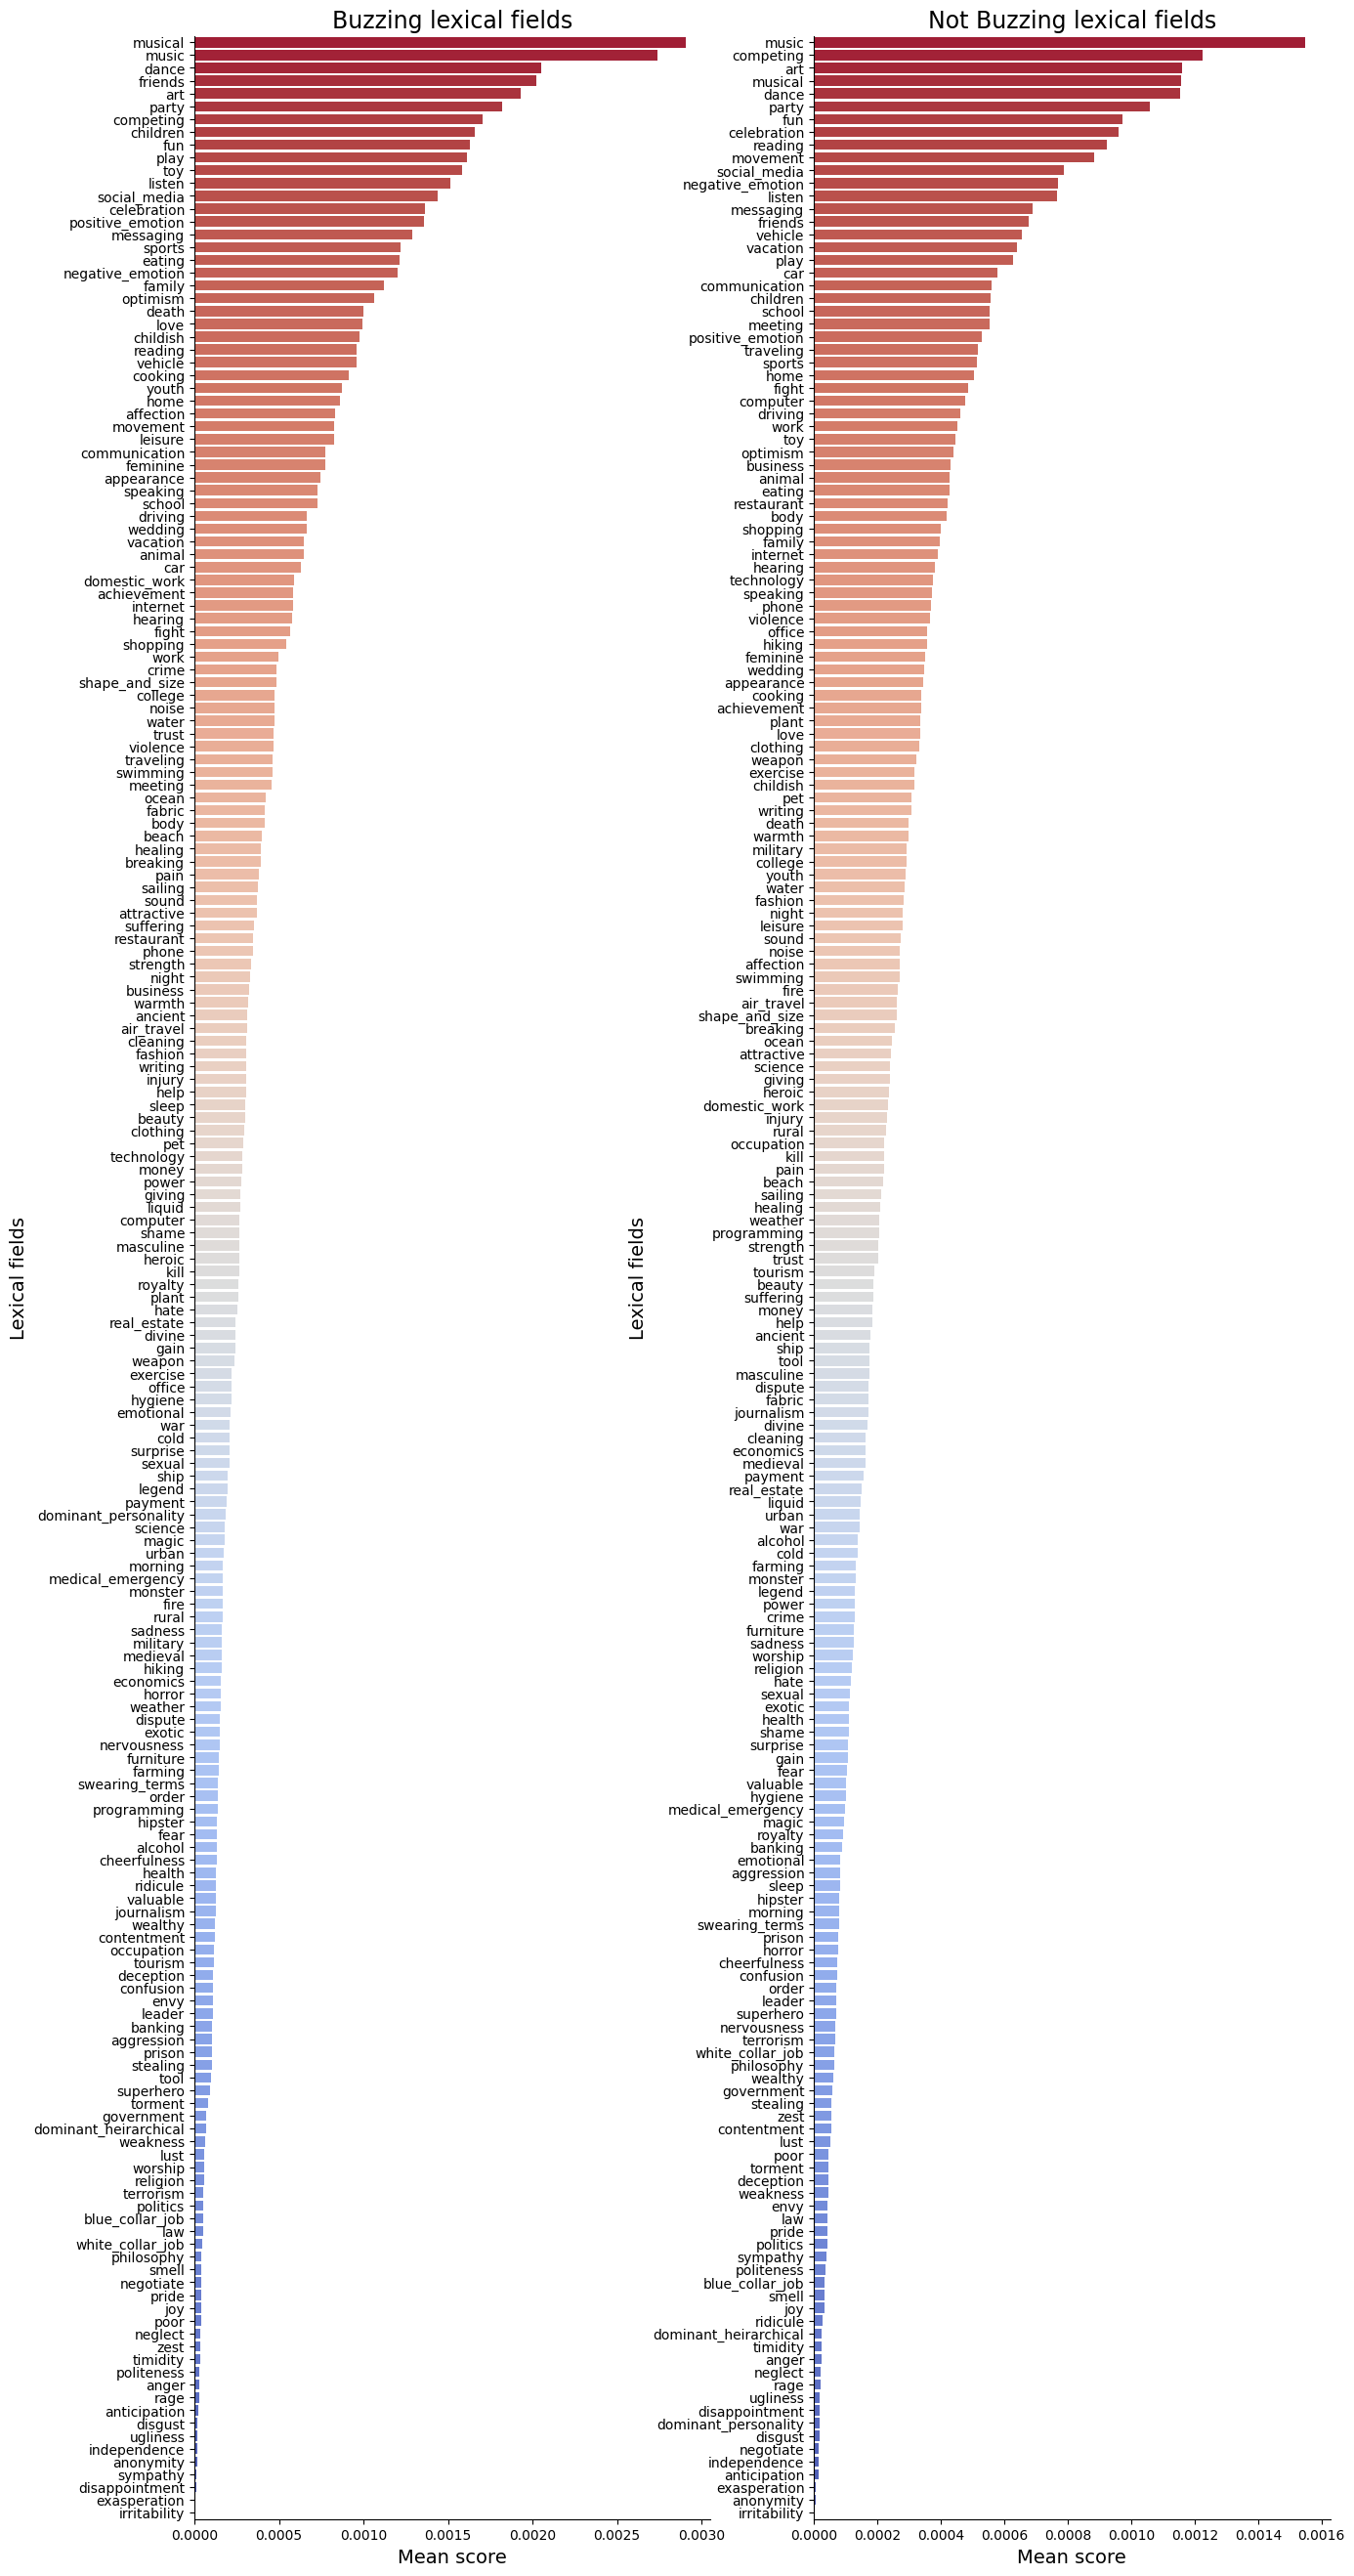

In [40]:
#plot the topics for buzzing and not buzzing videos

import seaborn as sns

fig, ax = plt.subplots(1,2, figsize=(15, 33))

palette = sns.color_palette("coolwarm", n_colors = len(categories_buzzing))
palette.reverse()

temp_df_1 = categories_buzzing.sort_values(by=['Buzzing'],  ascending=False)
sns.barplot(x = 'Buzzing', y = temp_df_1.index, data=temp_df_1, ax = ax[0], palette = palette)
ax[0].set_title("Buzzing lexical fields", fontsize = 17)
ax[0].set_xlabel("Mean score", fontsize = 14)
ax[0].set_ylabel("Lexical fields", fontsize = 14)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

palette = sns.color_palette("coolwarm", n_colors = len(categories_not_buzzing))
palette.reverse()

temp_df_2 = categories_not_buzzing.sort_values(by=['Not Buzzing'],  ascending=False)
sns.barplot(x = 'Not Buzzing', y = temp_df_2.index, data=temp_df_2, ax = ax[1], palette = palette)
ax[1].set_title("Not Buzzing lexical fields", fontsize = 17)
ax[1].set_xlabel("Mean score", fontsize = 14)
ax[1].set_ylabel("Lexical fields", fontsize = 14)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

##### Diagram of venn
plot the venn diagram of the topics for the buzzing and non buzzing videos

In [41]:
categories_not_buzzing.reset_index(inplace=True)
categories_buzzing.reset_index(inplace=True)


#number of quotes to keep per category
N = 15

#we isolate the 15 most common lexical fields from our three categories:
temp_df_1 = categories_buzzing.sort_values(by=['Buzzing'],  ascending=False, ignore_index=True)
Buz_LFs = temp_df_1.loc[:N-1,'index'].values
temp_df_2 = categories_not_buzzing.sort_values(by=['Not Buzzing'],  ascending=False, ignore_index=True)
Nbuz_LFs = temp_df_2.loc[:N-1,'index'].values


#we remove dupplicates:
most_common_LFs = np.concatenate([Buz_LFs, Nbuz_LFs])
most_common_LFs = np.array(most_common_LFs).ravel()
most_common_LFs = np.unique(most_common_LFs)

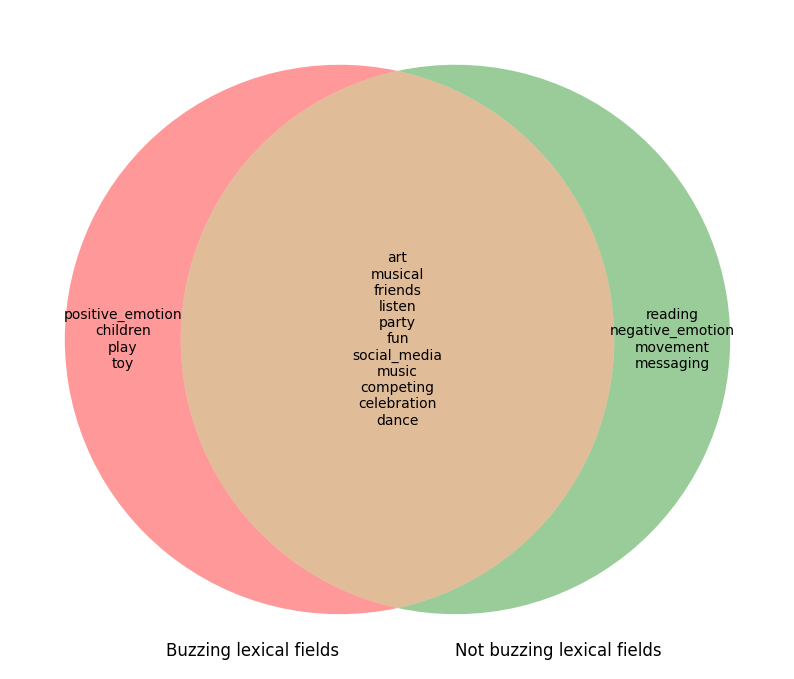

In [42]:
#Venn diagram
from matplotlib_venn import venn2
A = set(Buz_LFs)
B = set(Nbuz_LFs)

fig, ax = plt.subplots(1,1, figsize=(10, 10))

v = venn2([A, B], ('Buzzing lexical fields', "Not buzzing lexical fields"))

v.get_label_by_id('11').set_text('\n'.join(A&B))
v.get_label_by_id('10').set_text('\n'.join(A-B))
v.get_label_by_id('01').set_text('\n'.join(B-A))

##### Topics in general

Analysis of the topics in all the videos without doing the mean for each youtuber

This analysis has more significant results but the TA prefere the analysis above 

In [43]:
categories_df = []
categories_df.append(mean_lexical(buzz_videos['title']))
categories_df.append(mean_lexical(quiet_videos['title']))
categories_df = pd.DataFrame(categories_df, index = ['Buzzing','Not Buzzing']) 

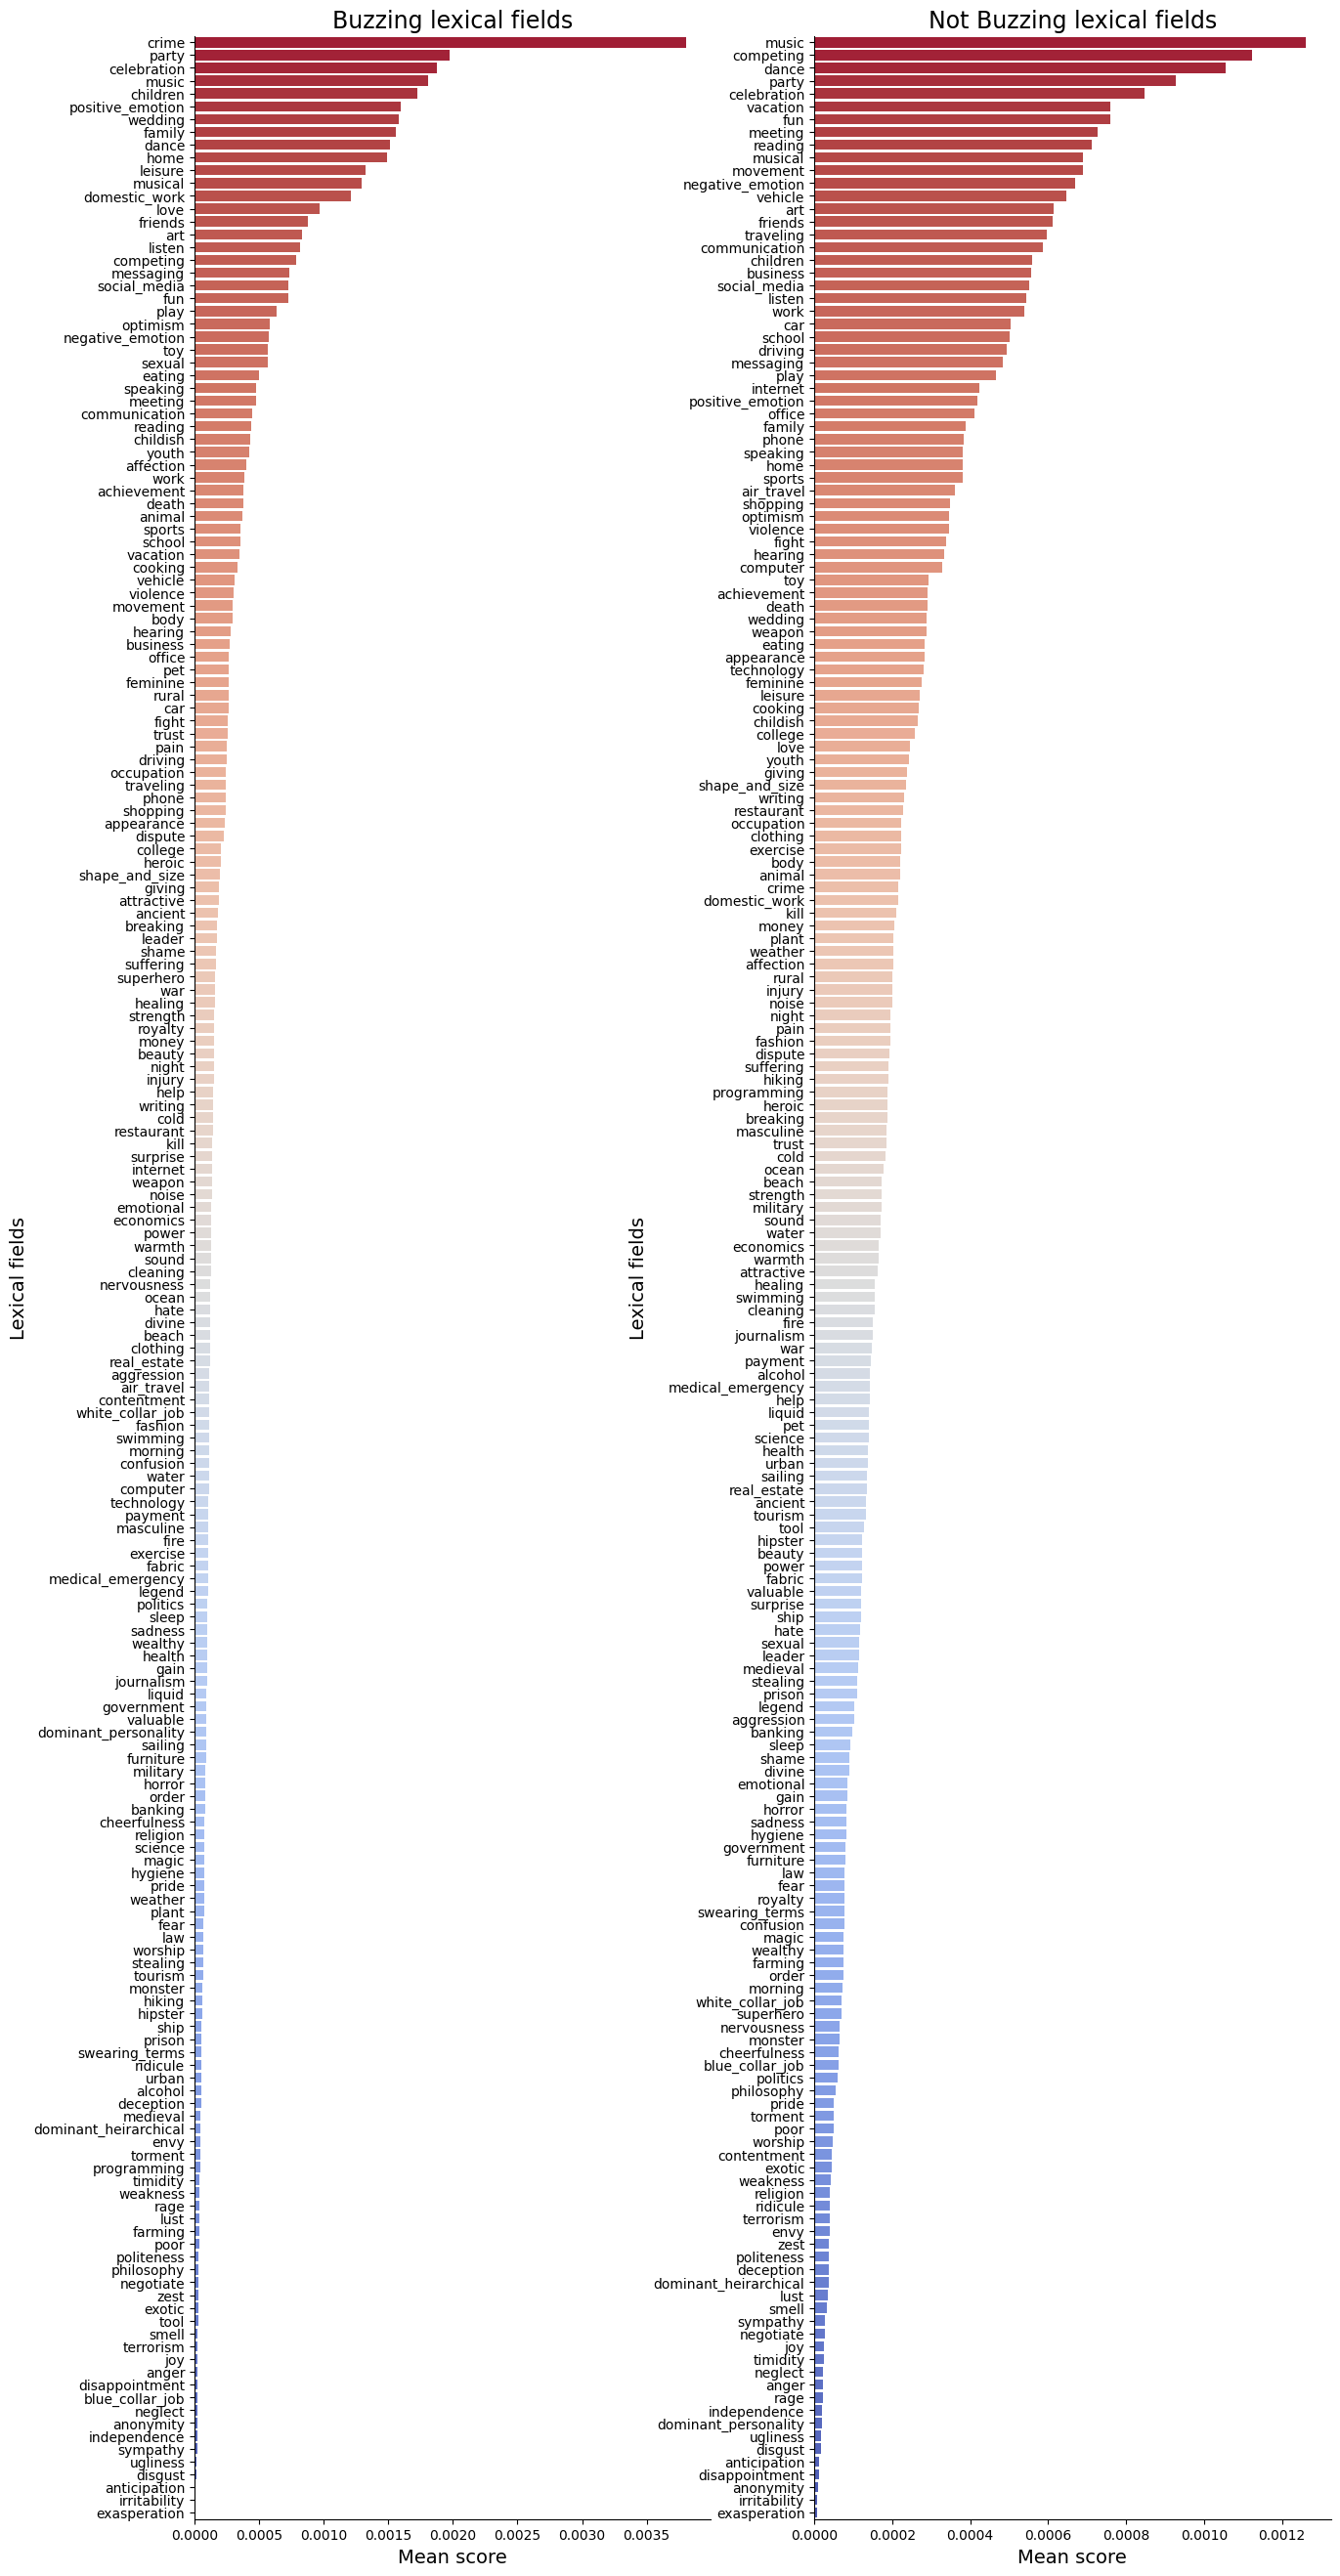

In [44]:
import seaborn as sns
temp_df = categories_df.copy().T 
temp_df.reset_index(inplace=True)

fig, ax = plt.subplots(1,2, figsize=(15, 33))

palette = sns.color_palette("coolwarm", n_colors = len(temp_df))
palette.reverse()

temp_df = temp_df.sort_values(by=['Buzzing'],  ascending=False)
sns.barplot(x = 'Buzzing', y = 'index', data=temp_df, ax = ax[0], palette = palette)
ax[0].set_title("Buzzing lexical fields", fontsize = 17)
ax[0].set_xlabel("Mean score", fontsize = 14)
ax[0].set_ylabel("Lexical fields", fontsize = 14)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

temp_df = temp_df.sort_values(by=['Not Buzzing'],  ascending=False)
sns.barplot(x = 'Not Buzzing', y = 'index', data=temp_df, ax = ax[1], palette = palette)
ax[1].set_title("Not Buzzing lexical fields", fontsize = 17)
ax[1].set_xlabel("Mean score", fontsize = 14)
ax[1].set_ylabel("Lexical fields", fontsize = 14)
ax[1].spines['right'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

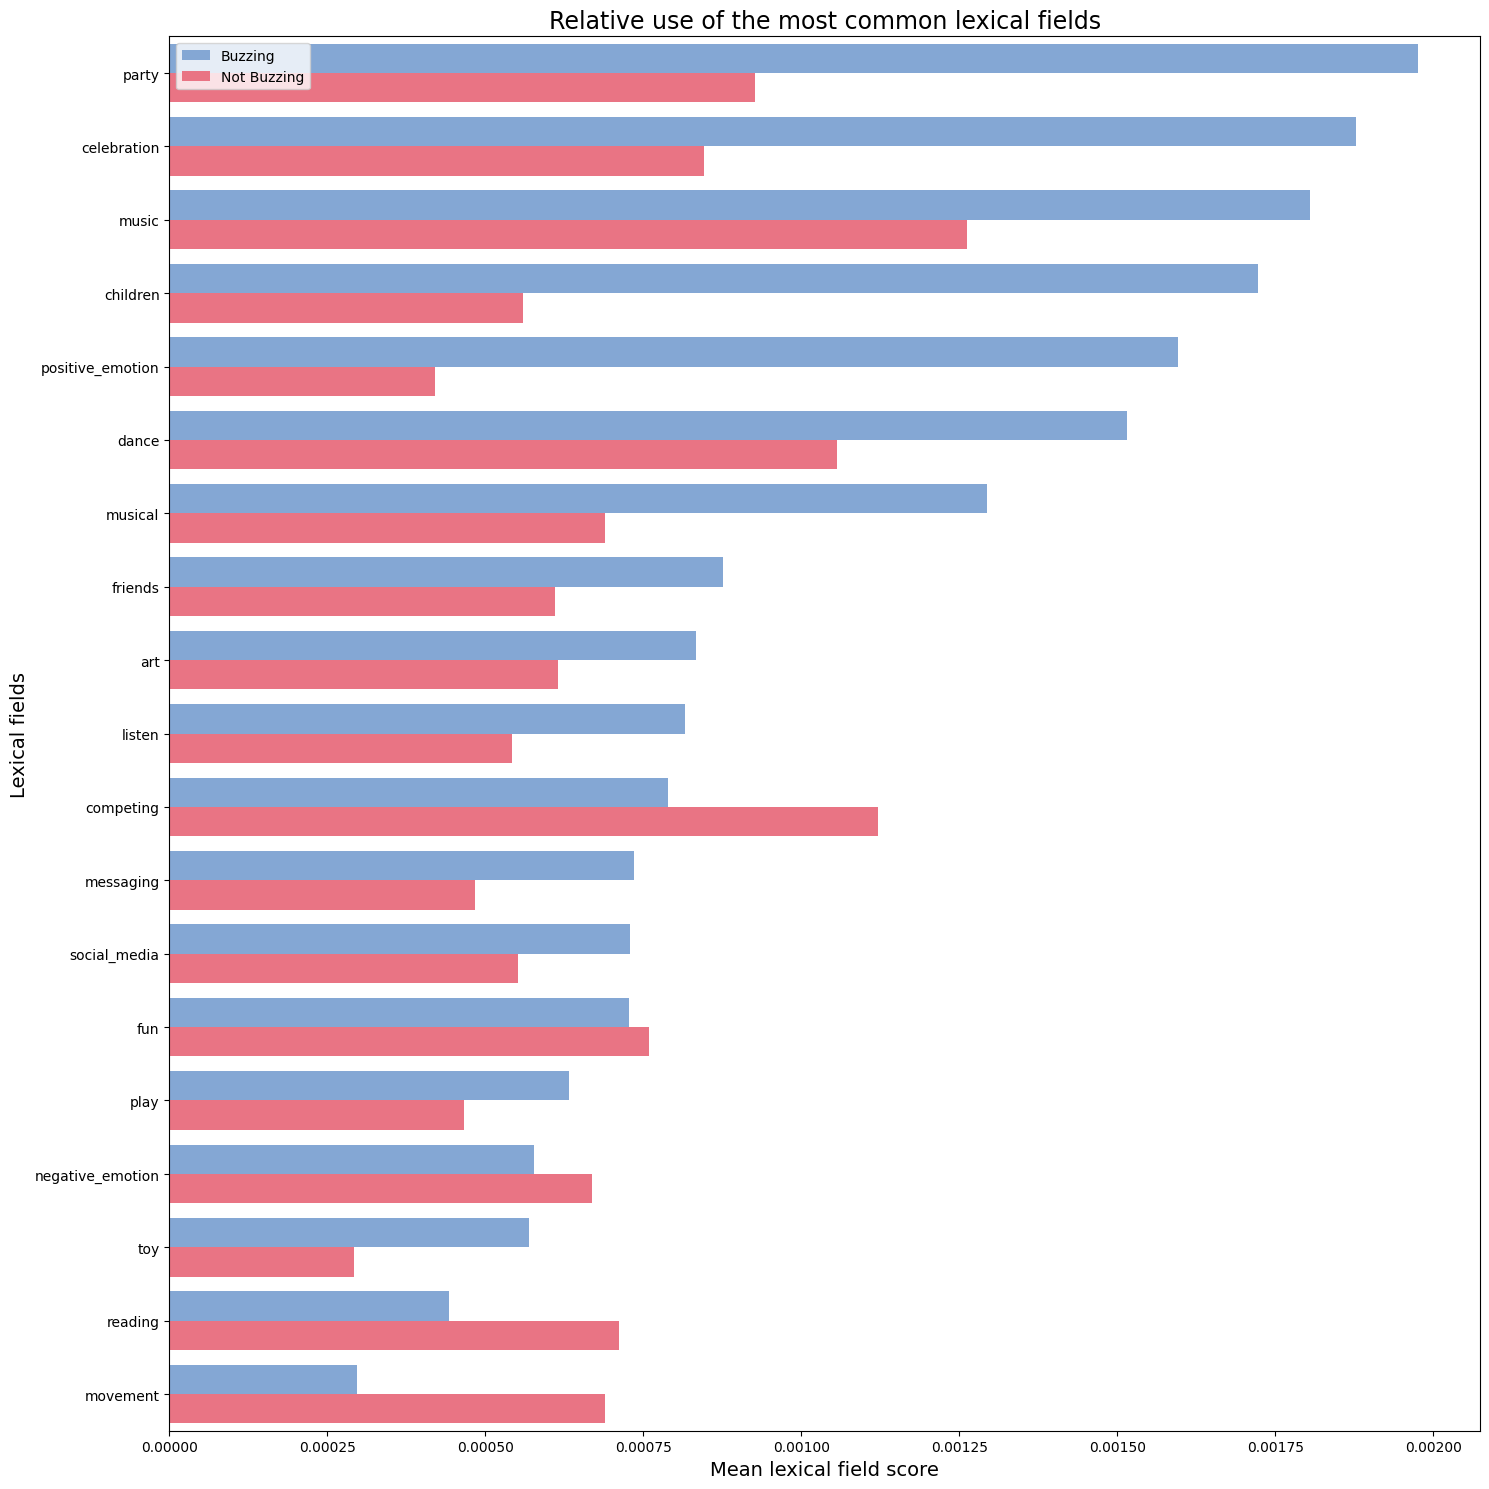

In [45]:
#we keep the 15 most common lexical fields of both buzzing and quiet
temp_df = categories_df.copy().T
temp_df = temp_df.loc[most_common_LFs]
temp_df.reset_index(inplace=True)
temp_df = temp_df.sort_values(by=['Buzzing', 'Not Buzzing'],  ascending=False)
temp_df = temp_df.melt(id_vars='index')

##create a custom palette to use the traditional republican and democrats parties colors
custom_colors = [ "#77a5e1","#fd6076"]
sns.set_palette(sns.color_palette(custom_colors))

#we build a barplot
fig, ax = plt.subplots(1,1, figsize=(15, 15))

sns.barplot(x = 'value', y = 'index', hue = 'variable', data = temp_df)

ax.set_title("Relative use of the most common lexical fields", fontsize = 17)
ax.set_xlabel("Mean lexical field score", fontsize = 14)
ax.set_ylabel("Lexical fields", fontsize = 14)
plt.legend(loc = 'upper left', facecolor="white")

fig.tight_layout(h_pad=2)

# transform to pie chart 

In [46]:
temp_df = categories_df.copy().T 
temp_df.reset_index(inplace=True)

#number of quotes to keep per category
N = 15

#we isolate the 15 most common lexical fields from our three categories:
temp_df = temp_df.sort_values(by=['Buzzing'],  ascending=False, ignore_index=True)
Buz_LFs = temp_df.loc[:N-1,'index'].values
temp_df = temp_df.sort_values(by=['Not Buzzing'],  ascending=False, ignore_index=True)
Nbuz_LFs = temp_df.loc[:N-1,'index'].values


#we remove dupplicates:
most_common_LFs = np.concatenate([Buz_LFs, Nbuz_LFs])
most_common_LFs = np.array(most_common_LFs).ravel()
most_common_LFs = np.unique(most_common_LFs)

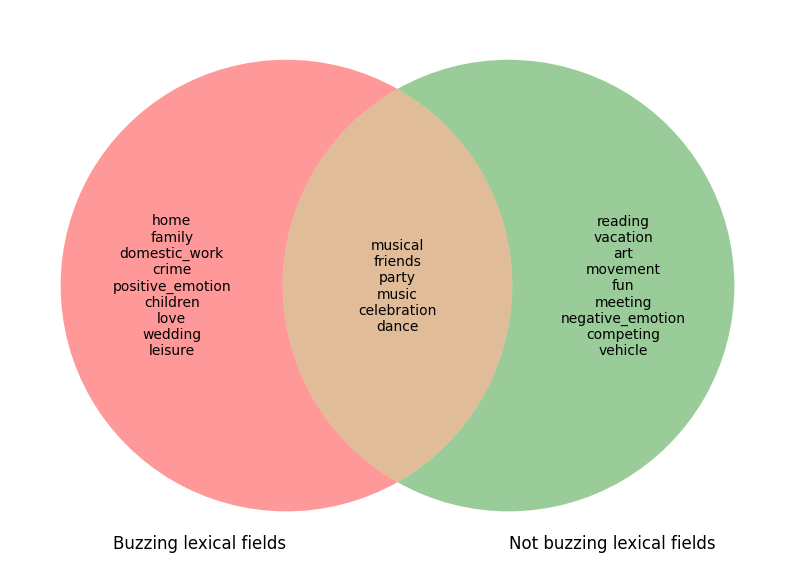

In [47]:
#Venn diagram
from matplotlib_venn import venn2
A = set(Buz_LFs)
B = set(Nbuz_LFs)

fig, ax = plt.subplots(1,1, figsize=(10, 10))

v = venn2([A, B], ('Buzzing lexical fields', "Not buzzing lexical fields"))

v.get_label_by_id('11').set_text('\n'.join(A&B))
v.get_label_by_id('10').set_text('\n'.join(A-B))
v.get_label_by_id('01').set_text('\n'.join(B-A))

# Sentiment analysis 

Do not work for now and we don't know if we keep it 

In [48]:
!pip install vaderSentiment

     -------------------------------------- 126.0/126.0 kB 1.8 MB/s eta 0:00:00


In [49]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentiment = SentimentIntensityAnalyzer()
text_1 = buzz_videos['title'][buzz_videos.channel=='UCztk4LFUIk4Ao4TCvpdnDsg']
text_2 =  "The pizza tastes terrible."
sent_1 = sentiment.polarity_scores(text_1)
sent_2 = sentiment.polarity_scores(text_2)
#transform sent_1 and sent_2 into a dataframe
sent_1 = pd.DataFrame.from_dict(sent_1, orient='index').T
sent_2 = pd.DataFrame.from_dict(sent_2, orient='index').T
sent_2

,neg,neu,pos,compound
0,0.508,0.492,0.0,-0.4767


In [50]:
sent_buzzing = []
for i in buzz_videos.channel.unique():
    sent_1 = sentiment.polarity_scores(buzz_videos['title'][buzz_videos.channel==i])
    sent_buzzing.append(pd.DataFrame.from_dict(sent_1, orient='index').T)
sent_buzzing = pd.DataFrame(sent_buzzing, index = buzz_videos.channel.unique())
    
sent_not_buzzing = []
for i in quiet_videos.channel.unique():
    sent_2 = sentiment.polarity_scores(quiet_videos['title'][quiet_videos.channel==i])
    sent_not_buzzing.append(pd.DataFrame.from_dict(sent_2, orient='index').T)
sent_not_buzzing = pd.DataFrame(sent_not_buzzing, index = quiet_videos.channel.unique())




KeyboardInterrupt: 